In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.semi_supervised import LabelSpreading
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import itertools
from tqdm import tqdm

# Define paths
folder_path_labeled = 'C:\\Users\\Administrator\\Downloads\\segmented_dt1\\segmented_dt1'
folder_path_unlabeled = 'C:\\Users\\Administrator\\Downloads\\segmented_UTC0_2-20250225T143732Z-001 (1)\\segmented_UTC0_2'

In [8]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define your folder paths here
folder_path_labeled = 'C:\\Users\\Administrator\\Downloads\\segmented_dt1\\segmented_dt1'
folder_path_unlabeled = 'C:\\Users\\Administrator\\Downloads\\segmented_UTC0_2-20250225T143732Z-001 (1)\\segmented_UTC0_2'

# Check if folders exist
print(f"Labeled data folder exists: {os.path.exists(folder_path_labeled)}")
print(f"Unlabeled data folder exists: {os.path.exists(folder_path_unlabeled)}")

# Show sample files if folders exist
if os.path.exists(folder_path_labeled):
    files = os.listdir(folder_path_labeled)
    print(f"Found {len(files)} files in labeled folder")
    print(f"Sample files: {files[:5]}")
else:
    print("Labeled folder not found. Please check the path.")
    
if os.path.exists(folder_path_unlabeled):
    files = os.listdir(folder_path_unlabeled)
    print(f"Found {len(files)} files in unlabeled folder")
    print(f"Sample files: {files[:5]}")
else:
    print("Unlabeled folder not found. Please check the path.")


Labeled data folder exists: True
Unlabeled data folder exists: True
Found 2448 files in labeled folder
Sample files: ['2806_segment_1.csv', '2806_segment_10.csv', '2806_segment_100.csv', '2806_segment_101.csv', '2806_segment_102.csv']
Found 46793 files in unlabeled folder
Sample files: ['1716_segment_1.csv', '1716_segment_2.csv', '2803_segment_1.csv', '2803_segment_10.csv', '2803_segment_100.csv']


In [9]:
def load_labeled_data(folder_path_labeled):
    """Load labeled data and extract features"""
    segments = []
    labels = []
    filenames = []
    
    for file in tqdm(os.listdir(folder_path_labeled)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_path_labeled, file))
            # Extract features from each segment - using uppercase X, Y, Z
            features = extract_features(df[['X', 'Y', 'Z']].values)
            segments.append(features)
            # Using 'Activity' column for labels
            labels.append(df['Activity'].iloc[0])  # Assuming all rows have same label
            filenames.append(file)
    
    return np.array(segments), np.array(labels), filenames

def load_unlabeled_data(folder_path_unlabeled, max_samples=None):
    """Load unlabeled data and extract features"""
    segments = []
    filenames = []
    
    file_list = os.listdir(folder_path_unlabeled)
    if max_samples:
        file_list = file_list[:max_samples]
    
    for file in tqdm(file_list):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_path_unlabeled, file))
            # Using uppercase X, Y, Z
            features = extract_features(df[['X', 'Y', 'Z']].values)
            segments.append(features)
            filenames.append(file)
    
    return np.array(segments), filenames

In [11]:
def load_labeled_data(folder_path_labeled):
    """Load labeled data and extract features"""
    segments = []
    labels = []
    filenames = []
    
    for file in tqdm(os.listdir(folder_path_labeled)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_path_labeled, file))
            # Extract features from each segment - using uppercase X, Y, Z
            features = extract_features(df[['X', 'Y', 'Z']].values)
            segments.append(features)
            # Using 'Activity' column for labels
            labels.append(df['Activity'].iloc[0])  # Assuming all rows have same label
            filenames.append(file)
    
    return np.array(segments), np.array(labels), filenames

def load_unlabeled_data(folder_path_unlabeled, max_samples=None):
    """Load unlabeled data and extract features"""
    segments = []
    filenames = []
    
    file_list = os.listdir(folder_path_unlabeled)
    if max_samples:
        file_list = file_list[:max_samples]
    
    for file in tqdm(file_list):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_path_unlabeled, file))
            # Using uppercase X, Y, Z
            features = extract_features(df[['X', 'Y', 'Z']].values)
            segments.append(features)
            filenames.append(file)
    
    return np.array(segments), filenames

def extract_features(xyz_data):
    """Extract more advanced features from xyz data"""
    features = []
    
    # Basic time domain features
    for axis in range(3):
        # Statistical features (with error handling)
        features.append(np.mean(xyz_data[:, axis]))
        features.append(np.std(xyz_data[:, axis]))
        features.append(np.max(xyz_data[:, axis]))
        features.append(np.min(xyz_data[:, axis]))
        features.append(np.median(xyz_data[:, axis]))
        
        # Add percentiles 
        features.append(np.percentile(xyz_data[:, axis], 25))  # 25th percentile
        features.append(np.percentile(xyz_data[:, axis], 75))  # 75th percentile
        
        # Safe higher order moments
        try:
            features.append(stats.iqr(xyz_data[:, axis]))
            features.append(stats.skew(xyz_data[:, axis]))
            features.append(stats.kurtosis(xyz_data[:, axis]))
        except:
            features.extend([0, 0, 0])
        
        # Zero crossing rate
        zero_crossings = np.where(np.diff(np.signbit(xyz_data[:, axis])))[0].size
        features.append(zero_crossings / len(xyz_data[:, axis]))
        
        # Signal energy and entropy
        energy = np.sum(xyz_data[:, axis]**2)
        features.append(energy / len(xyz_data[:, axis]))
        
        # Frequency domain features
        try:
            fft_vals = np.abs(np.fft.fft(xyz_data[:, axis]))
            features.append(np.mean(fft_vals))
            features.append(np.std(fft_vals))
            features.append(np.max(fft_vals))
            
            # Spectral centroid
            freqs = np.fft.fftfreq(len(xyz_data[:, axis]))
            features.append(np.sum(freqs * fft_vals) / np.sum(fft_vals + 1e-10))
            
            # Power spectral density
            psd = np.abs(fft_vals)**2
            features.append(np.mean(psd))
        except:
            features.extend([0, 0, 0, 0, 0])
    
    # Cross-axis correlations
    for i, j in [(0, 1), (0, 2), (1, 2)]:
        try:
            if np.std(xyz_data[:, i]) > 0 and np.std(xyz_data[:, j]) > 0:
                corr = np.corrcoef(xyz_data[:, i], xyz_data[:, j])[0, 1]
                features.append(0 if np.isnan(corr) else corr)
            else:
                features.append(0)
        except:
            features.append(0)
            
    # Magnitude and derivatives
    try:
        # Magnitude of acceleration
        magnitude = np.sqrt(np.sum(xyz_data**2, axis=1))
        features.append(np.mean(magnitude))
        features.append(np.std(magnitude))
        
        # First derivative (jerk)
        jerk = np.diff(xyz_data, axis=0)
        features.append(np.mean(np.sqrt(np.sum(jerk**2, axis=1))))
        
        # Second derivative (snap)
        snap = np.diff(jerk, axis=0)
        features.append(np.mean(np.sqrt(np.sum(snap**2, axis=1))))
    except:
        features.extend([0, 0, 0, 0])
    
    return np.array(features)

In [12]:
# Load data
print("Loading labeled data...")
X_labeled, y_labeled, labeled_files = load_labeled_data(folder_path_labeled)
print(f"Loaded {len(X_labeled)} labeled segments")

# Load unlabeled data
print("Loading unlabeled data...")
# Calculate ratio to limit unlabeled data
max_unlabeled = len(X_labeled) // 3
X_unlabeled, unlabeled_files = load_unlabeled_data(folder_path_unlabeled, max_samples=max_unlabeled)
print(f"Loaded {len(X_unlabeled)} unlabeled segments (limited to 1/3 of labeled)")

# Check for and handle NaN values
X_labeled_cleaned = np.nan_to_num(X_labeled, nan=0.0)
X_unlabeled_cleaned = np.nan_to_num(X_unlabeled, nan=0.0)

print(f"X_labeled shape: {X_labeled_cleaned.shape}")
print(f"y_labeled shape: {y_labeled.shape}")
print(f"X_unlabeled shape: {X_unlabeled_cleaned.shape}")

# Verify there are no infinite or NaN values
print(f"Any NaN in labeled data: {np.isnan(X_labeled_cleaned).any()}")
print(f"Any Inf in labeled data: {np.isinf(X_labeled_cleaned).any()}")
print(f"Any NaN in unlabeled data: {np.isnan(X_unlabeled_cleaned).any()}")
print(f"Any Inf in unlabeled data: {np.isinf(X_unlabeled_cleaned).any()}")

# Split labeled data for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled_cleaned, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled
)

Loading labeled data...


100%|██████████| 2448/2448 [00:10<00:00, 244.72it/s]


Loaded 2448 labeled segments
Loading unlabeled data...


  6%|▋         | 52/816 [00:00<00:03, 254.45it/s]c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 13%|█▎        | 104/816 [00:00<00:02, 255.73it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_13368\4219036827.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features.append(stats.skew(xyz_data[:, axis]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13368\4219036827.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features.append(stats.kurt

Loaded 816 unlabeled segments (limited to 1/3 of labeled)
X_labeled shape: (2448, 58)
y_labeled shape: (2448,)
X_unlabeled shape: (816, 58)
Any NaN in labeled data: False
Any Inf in labeled data: False
Any NaN in unlabeled data: False
Any Inf in unlabeled data: False


In [16]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [17]:
# 1. Prepare data for semi-supervised learning
print("Preparing data for semi-supervised learning...")

# Create labels for unlabeled data (-1 is the convention for unlabeled)
y_unlabeled = np.full(X_unlabeled_cleaned.shape[0], -1)

# Combine labeled training data with unlabeled data
X_combined = np.vstack((X_train, X_unlabeled_cleaned))
y_combined = np.concatenate((y_train, y_unlabeled))

# Print data shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_unlabeled shape: {X_unlabeled_cleaned.shape}")
print(f"X_combined shape: {X_combined.shape}")

# Check class distribution in labeled data
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("\nClass distribution in training data:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples ({count/len(y_train)*100:.2f}%)")

Preparing data for semi-supervised learning...
X_train shape: (1958, 58)
X_test shape: (490, 58)
X_unlabeled shape: (816, 58)
X_combined shape: (2774, 58)

Class distribution in training data:
Class 1: 251 samples (12.82%)
Class 2: 214 samples (10.93%)
Class 3: 154 samples (7.87%)
Class 4: 149 samples (7.61%)
Class 5: 160 samples (8.17%)
Class 6: 194 samples (9.91%)
Class 7: 64 samples (3.27%)
Class 8: 167 samples (8.53%)
Class 9: 282 samples (14.40%)
Class 10: 323 samples (16.50%)


In [18]:
# 2. Feature scaling
print("\nPerforming feature scaling...")

# Try both standard and robust scaling - robust often works better for time series data
standard_scaler = StandardScaler()
X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)
X_combined_std = standard_scaler.transform(X_combined)

robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train)
X_test_robust = robust_scaler.transform(X_test)
X_combined_robust = robust_scaler.transform(X_combined)

# Choose which scaling to use - robust scaling is often better for time series data
# but we'll proceed with standard scaling for now
X_train_scaled = X_train_std
X_test_scaled = X_test_std
X_combined_scaled = X_combined_std

print("Feature scaling complete")


Performing feature scaling...
Feature scaling complete


In [19]:
# 3. Feature selection and engineering
print("\nPerforming feature selection and engineering...")

# Try different feature selection methods
print("Using f_classif for feature selection...")
selector_f = SelectKBest(f_classif, k=min(30, X_combined_scaled.shape[1]))
selector_f.fit(X_train_scaled, y_train)
X_train_f = selector_f.transform(X_train_scaled)
X_test_f = selector_f.transform(X_test_scaled)
X_combined_f = selector_f.transform(X_combined_scaled)

print("Using mutual_info_classif for feature selection...")
selector_mi = SelectKBest(mutual_info_classif, k=min(30, X_combined_scaled.shape[1]))
selector_mi.fit(X_train_scaled, y_train)
X_train_mi = selector_mi.transform(X_train_scaled)
X_test_mi = selector_mi.transform(X_test_scaled)
X_combined_mi = selector_mi.transform(X_combined_scaled)

# Choose which feature selection method to use
# For time series data, mutual information often captures more complex relationships
X_train_selected = X_train_mi
X_test_selected = X_test_mi
X_combined_selected = X_combined_mi
selector = selector_mi

print(f"Features reduced from {X_combined_scaled.shape[1]} to {X_train_selected.shape[1]}")

# Optional: Apply PCA for further dimensionality reduction
apply_pca = False
if apply_pca:
    n_components = min(15, X_train_selected.shape[1])
    pca = PCA(n_components=n_components)
    X_train_selected = pca.fit_transform(X_train_selected)
    X_test_selected = pca.transform(X_test_selected)
    X_combined_selected = pca.transform(X_combined_selected)
    print(f"Applied PCA: reduced to {n_components} components")
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")


Performing feature selection and engineering...
Using f_classif for feature selection...
Using mutual_info_classif for feature selection...
Features reduced from 58 to 30


In [20]:
# 4. Define semi-supervised models
print("\nDefining semi-supervised models...")

# Define models to try with tuned hyperparameters for time series data
models = {
    "LabelSpreading (RBF)": LabelSpreading(
        kernel='rbf', 
        gamma=0.2,
        n_jobs=-1,
        max_iter=200
    ),
    "LabelSpreading (KNN)": LabelSpreading(
        kernel='knn', 
        n_neighbors=7, 
        n_jobs=-1,
        max_iter=200
    ),
    "LabelPropagation (RBF)": LabelPropagation(
        kernel='rbf', 
        gamma=0.2,
        n_jobs=-1,
        max_iter=200
    ),
    "SelfTraining (RF)": SelfTrainingClassifier(
        RandomForestClassifier(
            n_estimators=100, 
            max_depth=20,
            min_samples_split=5,
            random_state=42, 
            n_jobs=-1
        ),
        threshold=0.75
    ),
    "SelfTraining (GB)": SelfTrainingClassifier(
        GradientBoostingClassifier(
            n_estimators=100, 
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        ),
        threshold=0.75
    )
}

print(f"Defined {len(models)} semi-supervised models")


Defining semi-supervised models...
Defined 5 semi-supervised models


In [21]:
# 5. Train and evaluate models
print("\nTraining and evaluating models...")

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Fit the model
    model.fit(X_combined_selected, y_combined)
    
    # Predict on test set
    y_pred = model.predict(X_test_selected)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1': f1,
        'predictions': y_pred
    }

# Find best model based on F1 score
best_model_name = max(results, key=lambda k: results[k]['f1'])
best_model = results[best_model_name]['model']
best_f1 = results[best_model_name]['f1']
best_predictions = results[best_model_name]['predictions']

print(f"\nBest model: {best_model_name} with F1 Score: {best_f1:.4f}")


Training and evaluating models...

Training LabelSpreading (RBF)...
LabelSpreading (RBF) - Accuracy: 0.3061, F1 Score: 0.2842

Training LabelSpreading (KNN)...
LabelSpreading (KNN) - Accuracy: 0.3633, F1 Score: 0.3623

Training LabelPropagation (RBF)...
LabelPropagation (RBF) - Accuracy: 0.3041, F1 Score: 0.2831

Training SelfTraining (RF)...
SelfTraining (RF) - Accuracy: 0.4163, F1 Score: 0.4081

Training SelfTraining (GB)...
SelfTraining (GB) - Accuracy: 0.3796, F1 Score: 0.3748

Best model: SelfTraining (RF) with F1 Score: 0.4081


In [22]:
# 5. Train and evaluate models
print("\nTraining and evaluating models...")

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Fit the model
    model.fit(X_combined_selected, y_combined)
    
    # Predict on test set
    y_pred = model.predict(X_test_selected)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1': f1,
        'predictions': y_pred
    }

# Find best model based on F1 score
best_model_name = max(results, key=lambda k: results[k]['f1'])
best_model = results[best_model_name]['model']
best_f1 = results[best_model_name]['f1']
best_predictions = results[best_model_name]['predictions']

print(f"\nBest model: {best_model_name} with F1 Score: {best_f1:.4f}")


Training and evaluating models...

Training LabelSpreading (RBF)...
LabelSpreading (RBF) - Accuracy: 0.3061, F1 Score: 0.2842

Training LabelSpreading (KNN)...
LabelSpreading (KNN) - Accuracy: 0.3633, F1 Score: 0.3623

Training LabelPropagation (RBF)...
LabelPropagation (RBF) - Accuracy: 0.3041, F1 Score: 0.2831

Training SelfTraining (RF)...
SelfTraining (RF) - Accuracy: 0.4163, F1 Score: 0.4081

Training SelfTraining (GB)...
SelfTraining (GB) - Accuracy: 0.3796, F1 Score: 0.3748

Best model: SelfTraining (RF) with F1 Score: 0.4081


In [23]:
# 6. Detailed evaluation of the best model
print("\nDetailed evaluation of the best model:")
print(classification_report(y_test, best_predictions))

# Class-specific metrics
class_report = classification_report(y_test, best_predictions, output_dict=True)
df_report = pd.DataFrame(class_report).transpose()
print("\nClass-specific metrics:")
print(df_report)

# Identify challenging classes
challenging_classes = df_report[df_report['f1-score'] < 0.7].index.tolist()
if challenging_classes and 'accuracy' not in challenging_classes:
    print(f"\nClasses with lower performance (f1 < 0.7): {challenging_classes}")


Detailed evaluation of the best model:
              precision    recall  f1-score   support

           1       0.49      0.59      0.53        63
           2       0.36      0.40      0.38        53
           3       0.31      0.23      0.26        39
           4       0.31      0.30      0.30        37
           5       0.36      0.35      0.35        40
           6       0.39      0.46      0.42        48
           7       0.25      0.06      0.10        16
           8       0.37      0.38      0.38        42
           9       0.47      0.38      0.42        71
          10       0.50      0.57      0.53        81

    accuracy                           0.42       490
   macro avg       0.38      0.37      0.37       490
weighted avg       0.41      0.42      0.41       490


Class-specific metrics:
              precision    recall  f1-score     support
1              0.486842  0.587302  0.532374   63.000000
2              0.362069  0.396226  0.378378   53.000000
3       

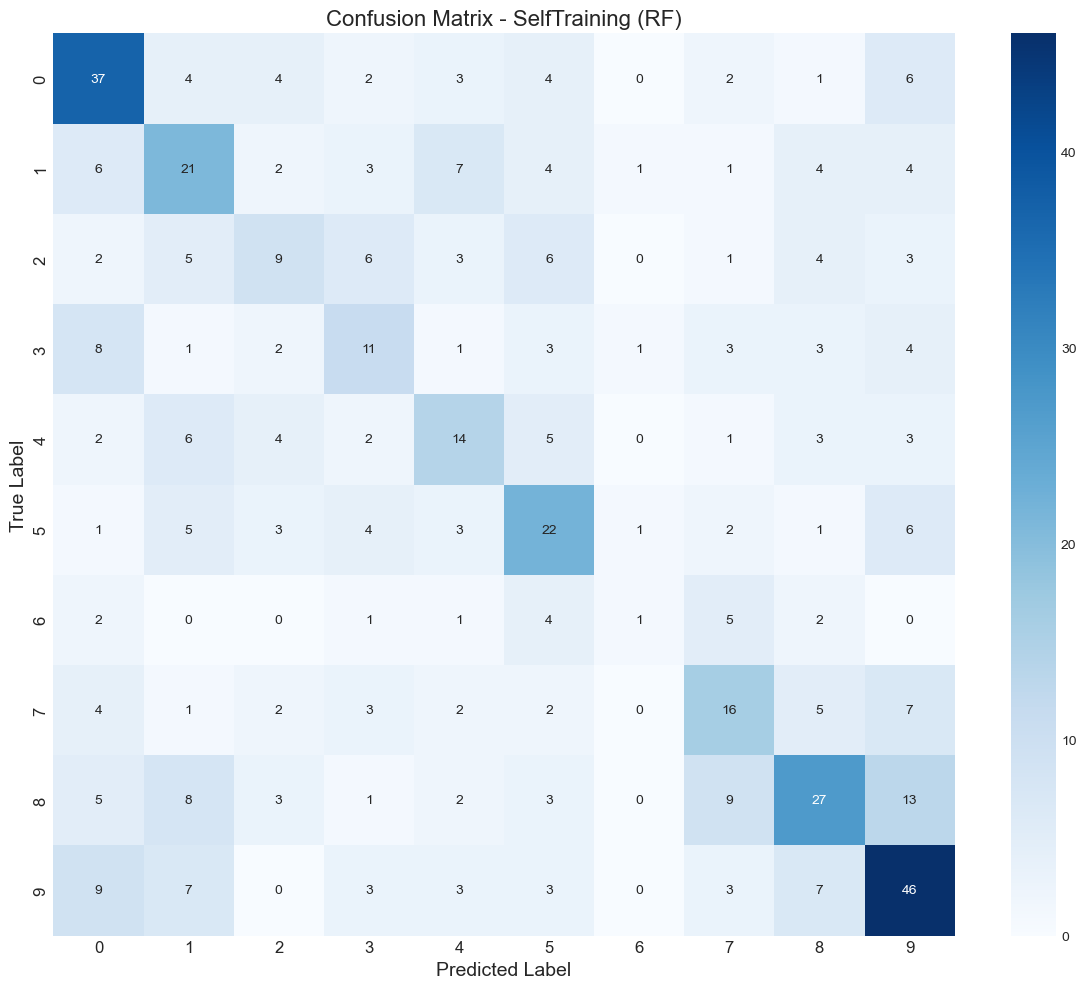

In [24]:
# 7. Confusion matrix visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

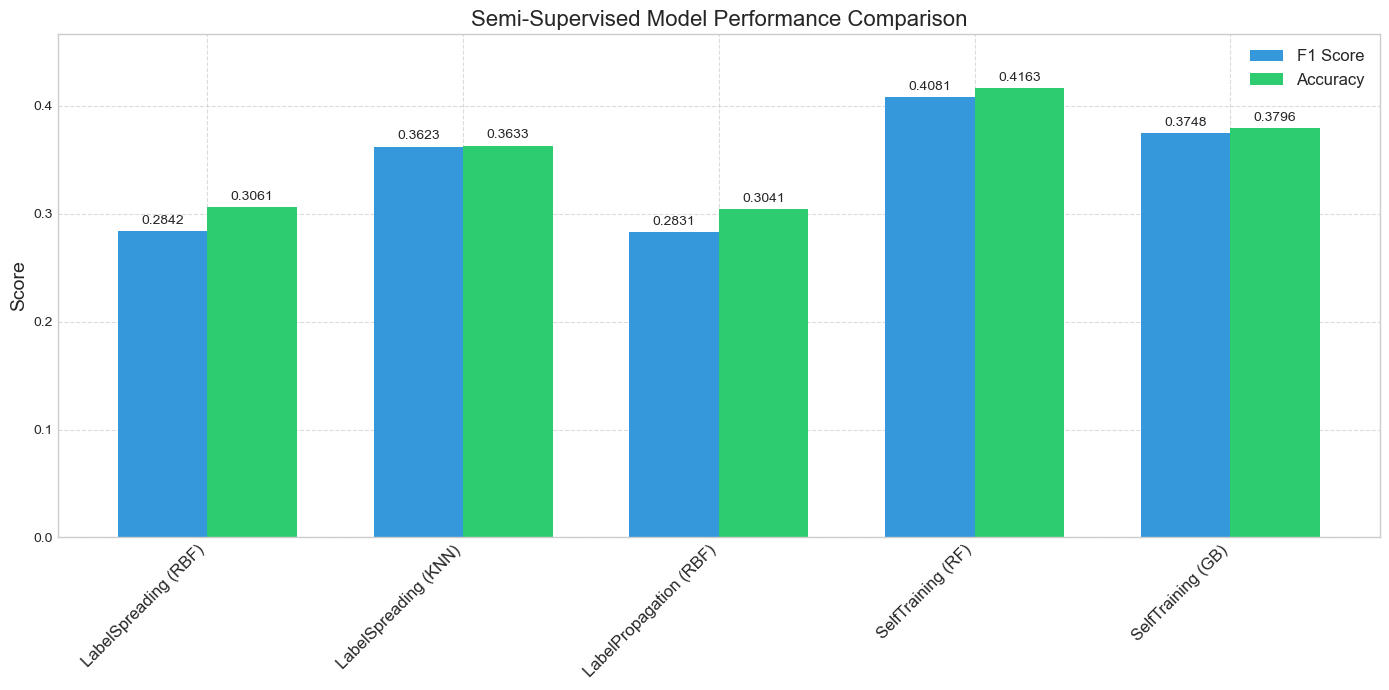

In [25]:
# 8. Visualize model comparison
plt.figure(figsize=(14, 7))
model_names = list(results.keys())
f1_scores = [results[name]['f1'] for name in model_names]
accuracy_scores = [results[name]['accuracy'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score', color='#3498db')
bars2 = ax.bar(x + width/2, accuracy_scores, width, label='Accuracy', color='#2ecc71')

# Add values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                   xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=10)

ax.set_ylabel('Score', fontsize=14)
ax.set_title('Semi-Supervised Model Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, max(max(f1_scores), max(accuracy_scores)) + 0.05)

plt.tight_layout()
plt.show()

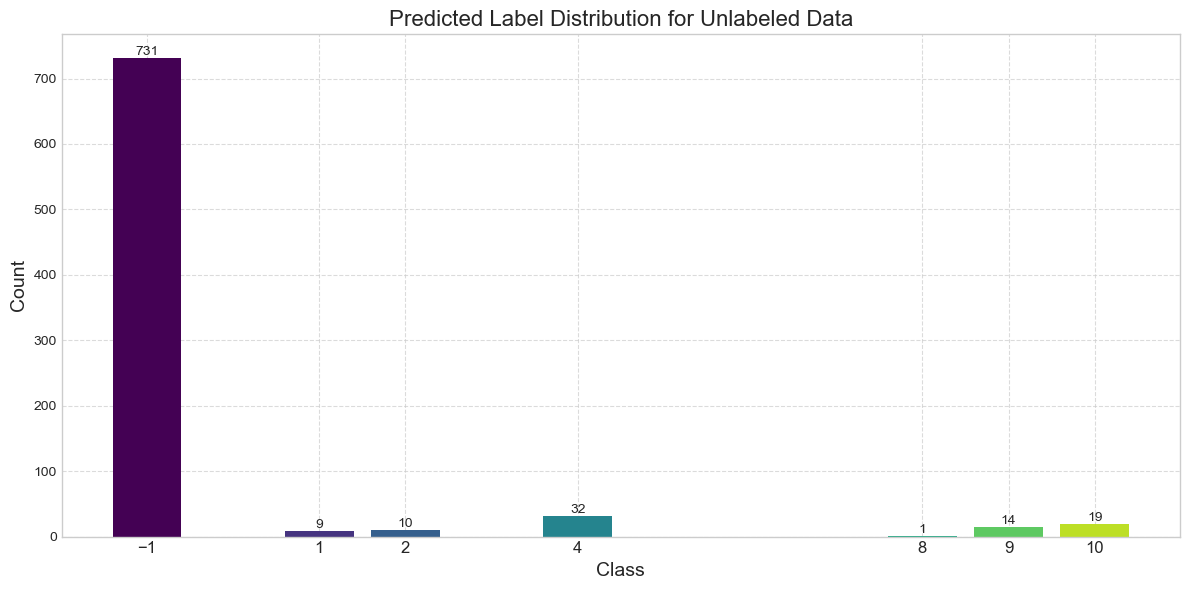

<Figure size 1400x600 with 0 Axes>

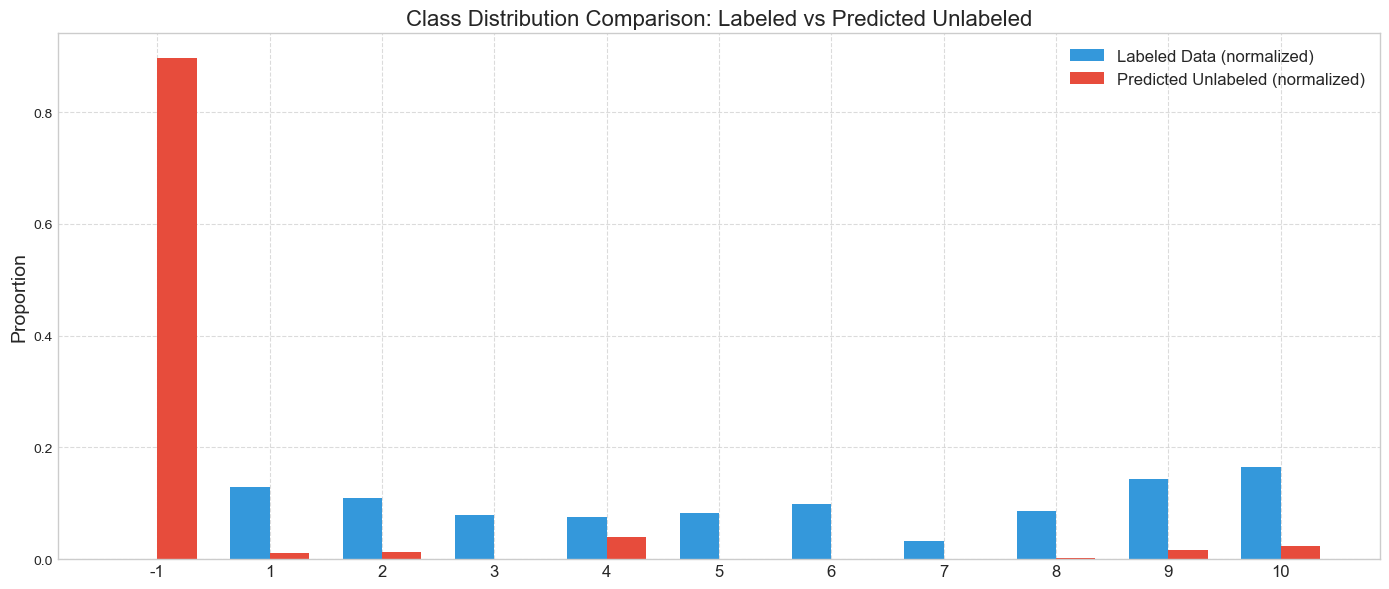

In [26]:
# 9. Label distribution in predicted unlabeled data
if hasattr(best_model, "transduction_"):
    # Get predicted labels for unlabeled data
    unlabeled_predictions = best_model.transduction_[-len(X_unlabeled_cleaned):]
    
    # Plot distribution
    plt.figure(figsize=(12, 6))
    unique_labels, counts = np.unique(unlabeled_predictions, return_counts=True)
    
    # Sort by label
    sorted_indices = np.argsort(unique_labels)
    unique_labels = unique_labels[sorted_indices]
    counts = counts[sorted_indices]
    
    # Create bars with different colors
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(unique_labels)))
    bars = plt.bar(unique_labels, counts, color=colors)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height}', ha='center', va='bottom')
    
    plt.title('Predicted Label Distribution for Unlabeled Data', fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(unique_labels, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Compare labeled vs predicted distributions
    plt.figure(figsize=(14, 6))
    
    # Get labeled data distribution
    labeled_unique, labeled_counts = np.unique(y_train, return_counts=True)
    labeled_counts_norm = labeled_counts / labeled_counts.sum()
    
    # Get predicted unlabeled distribution
    unlabeled_unique, unlabeled_counts = np.unique(unlabeled_predictions, return_counts=True)
    
    # Create a complete set of classes
    all_classes = np.unique(np.concatenate((labeled_unique, unlabeled_unique)))
    
    # Create complete counts arrays with zeros for missing classes
    labeled_complete = np.zeros(len(all_classes))
    unlabeled_complete = np.zeros(len(all_classes))
    
    for i, cls in enumerate(all_classes):
        if cls in labeled_unique:
            labeled_complete[i] = labeled_counts_norm[np.where(labeled_unique == cls)[0][0]]
        if cls in unlabeled_unique:
            unlabeled_complete[i] = unlabeled_counts[np.where(unlabeled_unique == cls)[0][0]] / unlabeled_counts.sum()
    
    # Plot side by side
    x = np.arange(len(all_classes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width/2, labeled_complete, width, label='Labeled Data (normalized)', color='#3498db')
    ax.bar(x + width/2, unlabeled_complete, width, label='Predicted Unlabeled (normalized)', color='#e74c3c')
    
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_title('Class Distribution Comparison: Labeled vs Predicted Unlabeled', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(all_classes, fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


Generating learning curves...


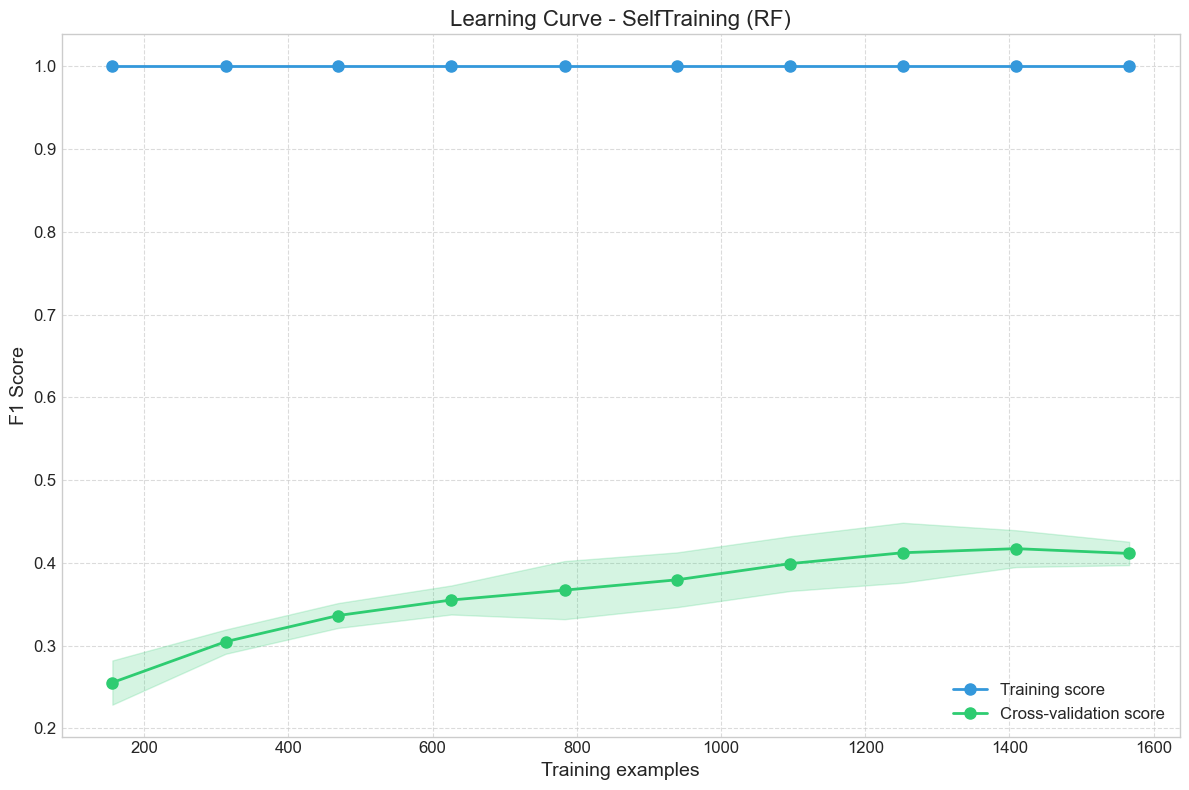

In [27]:
# 10. Learning curve analysis
print("\nGenerating learning curves...")

# Get best model class to retrain with different training sizes
if best_model_name.startswith("LabelSpreading"):
    model_class = LabelSpreading
    params = best_model.get_params()
elif best_model_name.startswith("LabelPropagation"):
    model_class = LabelPropagation
    params = best_model.get_params()
else:
    model_class = SelfTrainingClassifier
    if 'RF' in best_model_name:
        params = {'base_estimator': RandomForestClassifier(n_estimators=100, random_state=42)}
    else:
        params = {'base_estimator': GradientBoostingClassifier(n_estimators=100, random_state=42)}

# Calculate learning curve on labeled data only
train_sizes, train_scores, test_scores = learning_curve(
    model_class(**params),
    X_train_selected, 
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

# Plot learning curve
plt.figure(figsize=(12, 8))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid(True, linestyle='--', alpha=0.7)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="#3498db")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="#2ecc71")
plt.plot(train_sizes, train_scores_mean, 'o-', color="#3498db", linewidth=2, markersize=8, label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="#2ecc71", linewidth=2, markersize=8, label="Cross-validation score")

plt.title(f"Learning Curve - {best_model_name}", fontsize=16)
plt.xlabel("Training examples", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()


Analyzing feature importance...


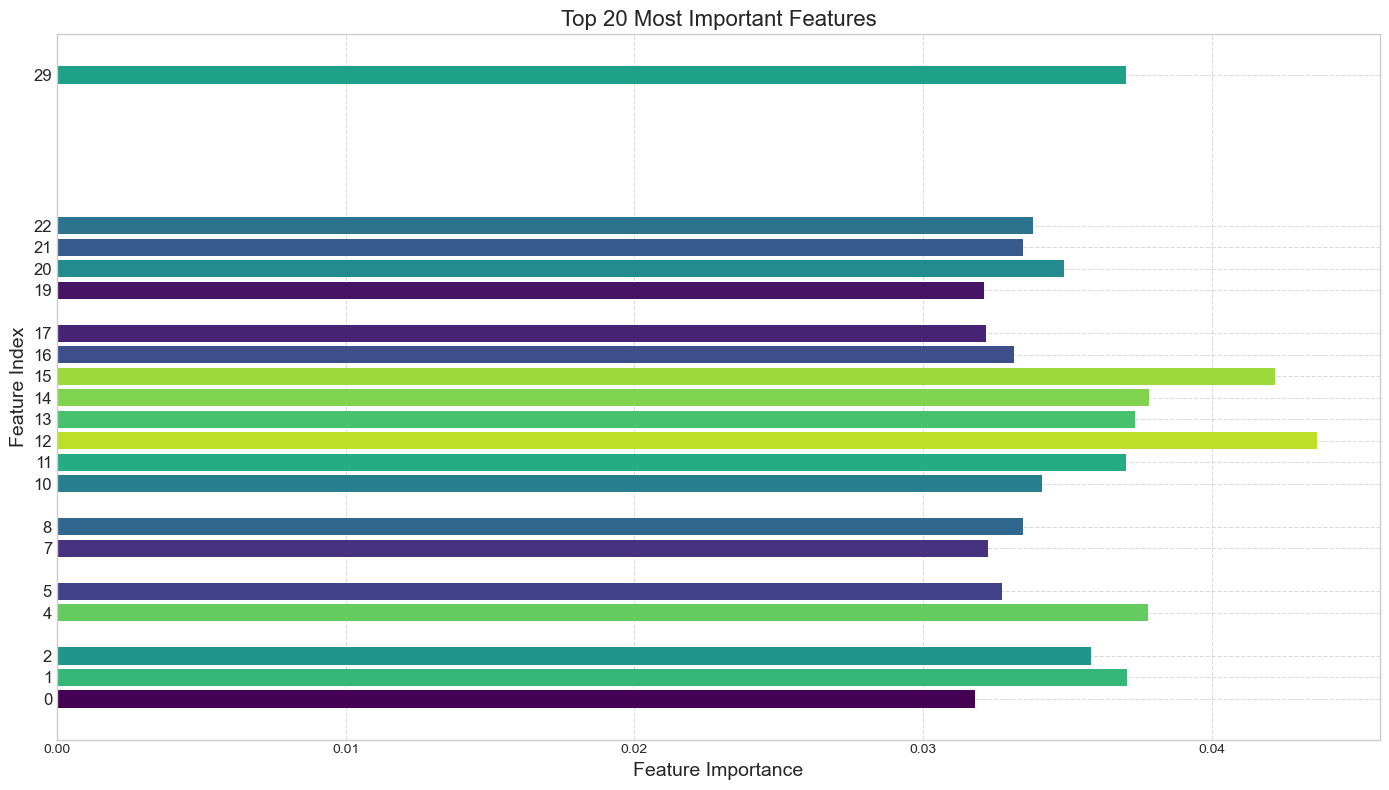

Top 20 important features (indices): 0, 19, 17, 7, 5, 16, 21, 8, 22, 10, 20, 2, 29, 11, 1, 13, 4, 14, 15, 12


In [28]:
# 11. Feature importance analysis
if hasattr(best_model, 'base_estimator_') and hasattr(best_model.base_estimator_, 'feature_importances_'):
    print("\nAnalyzing feature importance...")
    # Get feature importances from the base model (for SelfTrainingClassifier with tree-based models)
    feature_importances = best_model.base_estimator_.feature_importances_
    
    # Get feature indices
    feature_indices = np.arange(X_combined_selected.shape[1])
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importances)
    
    # Plot feature importances - top 20 or all if less than 20
    top_n = min(20, len(feature_indices))
    
    plt.figure(figsize=(14, 8))
    plt.barh(
        feature_indices[sorted_idx][-top_n:], 
        feature_importances[sorted_idx][-top_n:],
        color=plt.cm.viridis(np.linspace(0, 0.9, top_n))
    )
    plt.xlabel('Feature Importance', fontsize=14)
    plt.ylabel('Feature Index', fontsize=14)
    plt.title(f'Top {top_n} Most Important Features', fontsize=16)
    plt.yticks(feature_indices[sorted_idx][-top_n:], fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Save top features to a variable
    top_features = sorted_idx[-top_n:]
    print(f"Top {len(top_features)} important features (indices): {', '.join(map(str, top_features))}")

In [29]:
# 12. Save the best model and preprocessing components
print("\nSaving models and preprocessors to disk...")

# Create a model directory if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save with timestamp for versioning
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

model_path = f"models/best_model_{timestamp}.pkl"
scaler_path = f"models/scaler_{timestamp}.pkl"
selector_path = f"models/selector_{timestamp}.pkl"

# Save models and preprocessors
joblib.dump(best_model, model_path)
joblib.dump(standard_scaler, scaler_path) 
joblib.dump(selector, selector_path)

print(f"Saved best model: {model_path}")
print(f"Saved scaler: {scaler_path}")
print(f"Saved selector: {selector_path}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'f1_score': best_f1,
    'timestamp': timestamp,
    'feature_count': X_train_selected.shape[1],
    'train_samples': len(X_train),
    'unlabeled_samples': len(X_unlabeled_cleaned)
}

import json
with open(f"models/metadata_{timestamp}.json", 'w') as f:
    json.dump(metadata, f, indent=4)


Saving models and preprocessors to disk...
Saved best model: models/best_model_20250226_214735.pkl
Saved scaler: models/scaler_20250226_214735.pkl
Saved selector: models/selector_20250226_214735.pkl


In [30]:
# 13. Function to make predictions on new data
def predict_on_new_data(new_data, model_timestamp=timestamp):
    """
    Make predictions on new data using the trained model
    
    Args:
        new_data: numpy array of shape matching the training data
        model_timestamp: timestamp string to identify model files
        
    Returns:
        predictions: numpy array of predicted labels
    """
    # Load models
    model = joblib.load(f"models/best_model_{model_timestamp}.pkl")
    scaler = joblib.load(f"models/scaler_{model_timestamp}.pkl")
    selector = joblib.load(f"models/selector_{model_timestamp}.pkl")
    
    # Preprocess
    new_data_scaled = scaler.transform(new_data)
    new_data_selected = selector.transform(new_data_scaled)
    
    # Predict
    predictions = model.predict(new_data_selected)
    
    return predictions

# Simple function to predict on one sample
def predict_single_sample(sample, model=best_model, scaler=standard_scaler, selector=selector):
    """Predict on a single sample"""
    # Ensure sample is 2D for sklearn
    if sample.ndim == 1:
        sample = sample.reshape(1, -1)
        
    # Preprocess
    sample_scaled = scaler.transform(sample)
    sample_selected = selector.transform(sample_scaled)
    
    # Predict
    prediction = model.predict(sample_selected)[0]
    
    return prediction

print("\nSemi-supervised learning pipeline complete!")
print(f"Best model: {best_model_name} with F1 Score: {best_f1:.4f}")


Semi-supervised learning pipeline complete!
Best model: SelfTraining (RF) with F1 Score: 0.4081
